# Introduction to PerMaViss

This notebook introduces some of the objects and terminology used in PerMaViss. It explains in detail the used data structures, as well as the algorithmic intricacies of the persistence mayer vietoris algorithm.

© Copyright 2021, Álvaro Torras Casas, part of PerMaViss project.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

np.random.seed(10)


In [2]:
mpl.font_manager.FontManager(size=20)

# 1. Basic Persistent Homology using PerMaViss

### 1.1. Generating a Random Circle

We start by importing the necessary modules

In [3]:
import permaviss

from permaviss.sample_point_clouds.examples import random_circle, take_sample

We sample 100 points around a noisy circle of radius 1. Then we take a subsample of 20 points by using the min-max algorithm.

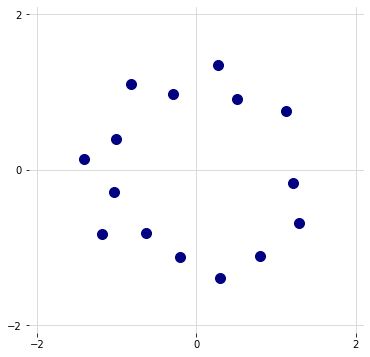

In [10]:
X = random_circle(100, 1, 0.5, seed=10)    # random points around a circle of radius 1
X = take_sample(X, 15, seed=4)   # subsample by using the min-max algorithm

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,6))
ax.set(frame_on=False)
ax.grid(c='lightgray')
ax.scatter(X[:,0], X[:,1], s=100, c='navy')
ax.set_xlim([-2.1,2.1])
ax.set_ylim([-2.1,2.1])
plt.xticks([-2,0,2])
plt.yticks([-2,0,2])
plt.savefig("figures/sample_circle.png", pad_inches=0.05, bbox_inches=None)

### 1.2. Computing the Vietoris-Rips complex

First, we import the modules implementing the construction of filtered complexes. We also import a scipy submodule for computing the distance matrices.

In [11]:
from permaviss.simplicial_complexes.vietoris_rips import vietoris_rips

import scipy.spatial.distance as dist

Dist_X = dist.squareform(dist.pdist(X))

Then we proceed to compute the Vietoris-Rips complex on top of $X$, we set the maximum filtration radius at value 4 and the maximum dimension at value 3. Notice that in the following example $C$ is a list of lists whose first entry indicates the number of vertices, the filtration values are stored on a separated list of lists $R$; both $C$ and $R$ share the same indexing system: [dimension][simplex index]. Simplices in $C$ are stored by the collection of vertices: $[v_1, v_2 ..., v_n]$.

In [18]:
max_r = 4
max_dim = 3
C, R = vietoris_rips(Dist_X, max_r, max_dim)
print("Number of vertices: " + str(C[0]))
print("=======================")
for dim, C_dim in enumerate(C):
    if dim > 0:
        print("Dimension: " + str(dim))
        print("=======================")
        for spx_idx, simplex in enumerate(C_dim):
            print(str(C_dim[spx_idx]) + " --> " + "{:.3f}".format(R[dim][spx_idx]))
            if spx_idx > 5: # limit the display to 5 simplices per dimension
                print("...\n")
                break
            

Number of vertices: 15
Dimension: 1
[ 5 14] --> 0.484
[ 4 13] --> 0.499
[ 7 12] --> 0.518
[ 6 11] --> 0.531
[ 2 10] --> 0.547
[6 9] --> 0.560
[ 1 11] --> 0.561
...

Dimension: 2
[ 1  8 11] --> 0.665
[ 5  8 14] --> 0.685
[ 4 10 13] --> 0.801
[ 2 10 14] --> 0.919
[3 6 9] --> 1.000
[1 5 8] --> 1.002
[ 3  7 12] --> 1.026
...

Dimension: 3
[ 1  6  8 11] --> 1.185
[ 1  5  8 11] --> 1.236
[ 1  5  8 14] --> 1.248
[ 1  5 11 14] --> 1.269
[ 1  8 11 14] --> 1.269
[ 5  8 11 14] --> 1.269
[ 2  4 10 13] --> 1.343
...



### Computing Classic Persistent Homology

In this section we compute persistent homology of $C$ by using the classic matrix approach with the twist implementation. 

In [13]:
import time
from permaviss.simplicial_complexes.differentials import complex_differentials
from permaviss.persistence_algebra.PH_classic import persistent_homology

We compute the differentials of $C$ on the base field $Z$ mod $5$. Afterwards we compute persistent homology. Notice that the current implementation is slow.

In [14]:
p = 5 # perform computations on Z mod 5

start = time.time()
Diff = complex_differentials(C, p=5)
end = time.time()
print("Computing differentials took " + "{:.2f}".format(end - start) + " seconds.")
start = end
Hom, Im, PreIm = persistent_homology(Diff, R, max_r, p)
end = time.time()
print("Computing persistent homology took " + "{:.2f}".format(end - start) + " seconds.")

Computing differentials took 32.63 seconds.
Computing persistent homology took 101.03 seconds.


We may plot the obtained persistence diagram and representatives by using the information contained in $Hom$.

In [15]:
print(Hom[1].barcode)
print(Hom[1].coordinates[:, 0])

[[0.93966454 1.94179243]]
[0. 4. 4. 4. 0. 1. 0. 0. 0. 4. 1. 1. 1. 1. 4. 0. 0. 1. 4. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


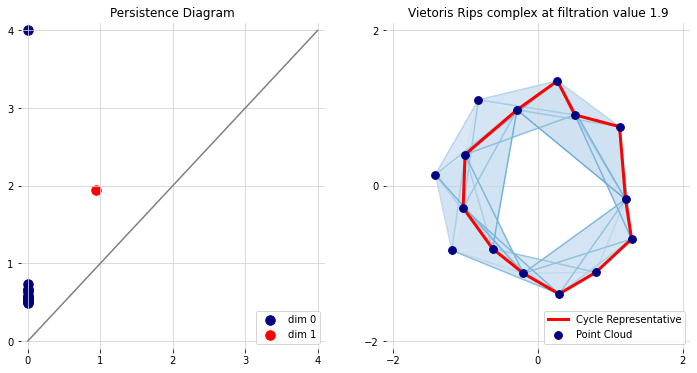

In [39]:
blues = mpl.cm.get_cmap('Blues') # get colormap for plotting
max_plotting_r = 1.9 # set maximum filtration for plotting purposes

fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

# plot point persistence diagram #################################################

ax0.set(frame_on=False)
ax0.grid(c='lightgray')

barcode0 = Hom[0].barcode
ax0.scatter(barcode0[:,0], barcode0[:,1], c='navy', s=90, label='dim 0')

barcode1 = Hom[1].barcode
ax0.scatter(barcode1[:,0], barcode1[:,1], c='red', s=90, label='dim 1')

ax0.plot([0, max_r], [0, max_r], c='gray') # plot diagonal 

# set axes layout
ax0.set_xlim([-0.1, max_r + 0.1])
ax0.set_ylim([-0.1, max_r + 0.1])
ax0.set_xticks(range(5))
ax0.set_yticks(range(5))
#set labels 
ax0.set_title("Persistence Diagram")
# avoid repeating labels on legend 
handles, labels = ax0.get_legend_handles_labels()
by_label = dict(zip(labels, handles)) # dictionary deletes repeating labels
ax0.legend(by_label.values(), by_label.keys(), loc='lower right')

# plot cycle representative #################################################

ax1.set(frame_on=False)
ax1.grid(c='lightgray')

# plot 2D simplices
for idx, triangle in enumerate(C[2]):
    if R[2][idx] < max_plotting_r:
        vertices = X[triangle]
        ax1.fill(vertices[:, 0], vertices[:, 1], facecolor=blues(R[2][idx]/(5*max_plotting_r)))
# plot edges 
for idx, edge in enumerate(C[1]):
    if R[1][idx] < max_plotting_r:
        vertices = X[edge]
        ax1.plot(vertices[:, 0], vertices[:, 1], color=blues(R[1][idx]/(2*max_plotting_r)))

# add cycle representative
for idx, coeff in enumerate(Hom[1].coordinates[:, 0]):
    if coeff != 0:
        edge = C[1][idx] # get edge from index
        vertices = X[edge] # recover vertices
        ax1.plot(vertices[:, 0], vertices[:, 1], color='red', linewidth=3, label='Cycle Representative')
        
# scatter plot 
ax1.scatter(X[:,0], X[:,1], s=60, c='navy', zorder=2.5, label='Point Cloud')

# set axes layout
ax1.set_xlim([-2.1,2.1])
ax1.set_ylim([-2.1,2.1])
ax1.set_xticks([-2,0,2])
ax1.set_yticks([-2,0,2])
#set labels 
ax1.set_title("Vietoris Rips complex at filtration value " + str(max_plotting_r))
# avoid repeating labels on legend 
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles)) # dictionary deletes repeating labels
ax1.legend(by_label.values(), by_label.keys(), loc='lower right')

# save figure ########################################################

plt.savefig("figures/diagram_rep_circle.png", pad_inches=0.05, bbox_inches=None)